# Spectral fitting using PyXspec
by Xiaoyuan Zhang @ MPE

This is a basic practice of using [PyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html) to fit cluster X-ray spectra. In this notebook, we will 
- deal with the background with the simplest approach, i.e. to subtract the *local background* spectrum from the source spectrum;
- fit the net spectrum with the xspec built-in maximum likelihood (or minimum c-stat) approach;
- esitmate the uncertainties of parameters using a built-in delta-fitting-statistic method;
- calculate source luminosity and observed flux from the best-fit model.

In [1]:
import os
import xspec as xs
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

First, we need to set a few parameters in xspec

In [2]:
xs.Fit.statMethod = "cstat"  # fitting statistics = Cash-statistics
xs.Xset.cosmo = "70 0 0.7"  # H0=70, q0=0, O_lambda=0.7
xs.Xset.abund = "aspl"  # Reference abundance table Asplund+09

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.
 Solar Abundance Vector set to aspl:  Asplund M., Grevesse N., Sauval A.J. & Scott P., ARAA, 47, 481 (2009)


### Background normalization scaling

Before loading the spectra, we need to calculate the scaling factor for the local background. The typical way is to scale the background spectra using the hard band count rate. 

In xspec, the background subtraction is performed as 
> $F_\mathrm{net}[\mathrm{cts/s}]=(C_\mathrm{src}/t_\mathrm{src}) - (C_\mathrm{bkg}/t_\mathrm{bkg})\times(BS_\mathrm{src}/BS_\mathrm{bkg})\times(AS_\mathrm{src}/AS_\mathrm{bkg})$, 

where $BS$ and $AS$ are **BACKSCAL** and **AREASCAL** values in the spectrum header. By default, **AREASCAL** value is one. 

Becasue we expect to have a zero count rate in the hard band of the net spectrum, we will have $$(C_\mathrm{src}/t_\mathrm{src})_\mathrm{hard} = (C_\mathrm{bkg}/t_\mathrm{bkg})_\mathrm{hard}\times(BS_\mathrm{src}/BS_\mathrm{bkg})$$

Given the **BACKSCAL** has been defined in SRCTOOL, let's have a check whether it can properly account for the background scaling or we need an additional factor $r$ to scale the background
$$r=(C_\mathrm{src}/t_\mathrm{src})_\mathrm{hard} / (C_\mathrm{bkg}/t_\mathrm{bkg})_\mathrm{hard} / (BS_\mathrm{src}/BS_\mathrm{bkg})$$

The calculation for $r$ by using the 6--9 keV band data is

In [3]:
specdata_src = fits.getdata("analysis/output_spectra/src_500kpc820_SourceSpec_00001.fits",
                            ext=1)["COUNTS"]
specdata_bkg = fits.getdata("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001.fits",
                            ext=1)["COUNTS"]
channel_elow = fits.getdata("analysis/output_spectra/src_500kpc820_RMF_00001.fits", 
                            ext=2)["E_MIN"]  # Channel energy bounds are stored in RMF files
exp_src = fits.getval("analysis/output_spectra/src_500kpc820_SourceSpec_00001.fits", 
                      "exposure", ext=1)
exp_bkg = fits.getval("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001.fits", 
                      "exposure", ext=1)
backscal_src = fits.getval("analysis/output_spectra/src_500kpc820_SourceSpec_00001.fits", 
                           "backscal", ext=1)
backscal_bkg = fits.getval("analysis/output_spectra/bkg_1p5-2deg820_SourceSpec_00001.fits", 
                           "backscal", ext=1)

channel_sel = (channel_elow > 6) & (channel_elow < 9)
areascal_ratio = (specdata_src[channel_sel].sum() / exp_src) / \
                 (specdata_bkg[channel_sel].sum() / exp_bkg) / \
                 (backscal_src / backscal_bkg)
areascal_ratio_err = areascal_ratio * (specdata_src[channel_sel].sum() ** -1. + specdata_bkg[channel_sel].sum()**-1.)**0.5
display(f"{areascal_ratio:.3f}+/-{areascal_ratio_err:.3f}")

'1.006+/-0.052'

The ratio is consistent to one and therefore we do not include an additional correction.

### Load the spectrum

In [4]:
# go to the directory of generated spectra + responses to load them
pwd = os.getcwd()
os.chdir("analysis/output_spectra/")



xs.Spectrum("src_500kpc820_SourceSpec_00001.grp", 
            backFile="bkg_1p5-2deg820_SourceSpec_00001.fits")

os.chdir(pwd)  # switch the current dirctory back


1 spectrum  in use
 
Spectral Data File: src_500kpc820_SourceSpec_00001.grp  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.023e+01 +/- 1.143e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-134
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 782.4 sec
 Using fit statistic: cstat
 Using Response (RMF) File            src_500kpc820_RMF_00001.fits for Source 1
 Using Auxiliary Response (ARF) File  src_500kpc820_ARF_00001.fits

Net count rate (cts/s) for Spectrum:1  6.904e+00 +/- 1.173e-01 (67.5 % total)
Spectrum 1  Spectral Data File: src_500kpc820_SourceSpec_00001.grp
Net count rate (cts/s) for Spectrum:1  6.904e+00 +/- 1.173e-01 (67.5 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-134
  Telescope: eROSITA Instrument: MERGED  Channel Type: PI
  Exposure Time: 782.4 sec
 Using fit statistic: cstat
 Using Background File                bkg_1p5-2deg820_SourceSpec_00001.fits
  Background Exposure Time: 3856 se

### Ignore channels with E < 0.3 keV and E > 7 keV

In [5]:
xs.AllData.ignore("**-0.3, 7.0-**")

     5 channels (1-5) ignored in spectrum #     1
    37 channels (98-134) ignored in spectrum #     1



### Set spectral model

We will use an absorbed collisional ionization equilibrium model (TBabs * apec) to model the spectrum.

The foreground Milkyway nH value is $6\times10^{20}$ cm$^{-2}$
(https://www.swift.ac.uk/analysis/nhtot/index.php)

In [6]:
model_obj = xs.Model("tbabs*apec")


Model TBabs<1>*apec<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   apec       kT         keV      1.00000      +/-  0.0          
   3    2   apec       Abundanc            1.00000      frozen
   4    2   apec       Redshift            0.0          frozen
   5    2   apec       norm                1.00000      +/-  0.0          
________________________________________________________________________

Reading APEC data from 3.0.9


Fit statistic  : C-Statistic                40995.33     using 92 bins.

Test statistic : Chi-Squared                222919.2     using 92 bins.
 Null hypothesis probability of 0.0e+00 with 89 degrees of freedom
 Current data and model not fit yet.


tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


### Fitting

Let's set the initial parameters and fit the spectrum

In [7]:
model_obj.TBabs.nH = 6e-2
model_obj.TBabs.nH.frozen = True

model_obj.apec.kT = 3
model_obj.apec.Redshift = 0.0129
model_obj.apec.Abundanc = 0.4

xs.Fit.renorm()
xs.Fit.perform()
xs.Fit.perform()


Fit statistic  : C-Statistic                271073.5     using 92 bins.

Test statistic : Chi-Squared              6.622116e+06     using 92 bins.
 Null hypothesis probability of 0.000000e+00 with 89 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                271073.5     using 92 bins.

Test statistic : Chi-Squared              6.622116e+06     using 92 bins.
 Null hypothesis probability of 0.000000e+00 with 90 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                81659.26     using 92 bins.

Test statistic : Chi-Squared                468448.0     using 92 bins.
 Null hypothesis probability of 0.0e+00 with 90 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                79390.87     using 92 bins.

Test statistic : Chi-Squared                447240.3     using 92 bins.
 Null hypothesis probability of 0.0e+00 with 90 degrees of freedom
 Current data and model

### visualize the best-fit spectrum

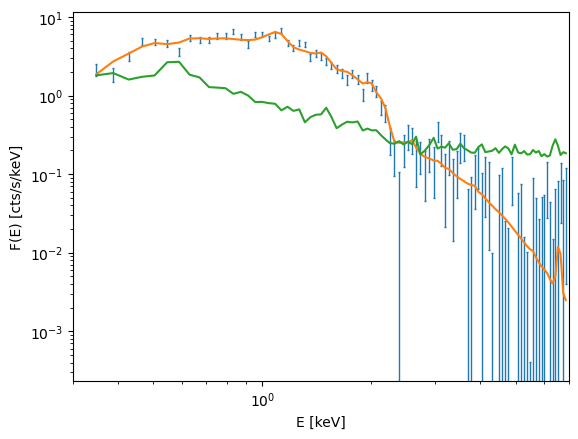

In [8]:
xs.Plot.xAxis = "keV"
xs.Plot.background = True
xs.Plot("data")
ener = xs.Plot.x()
spec = xs.Plot.y()
spec_err = xs.Plot.yErr()
spec_mo = xs.Plot.model()
spec_bkg = xs.Plot.backgroundVals()

plt.errorbar(ener, spec, yerr=spec_err, ls="", capsize=1, elinewidth=1)
plt.loglog(ener, spec_mo)
plt.loglog(ener,spec_bkg)
plt.xlim(0.3,7)
plt.xlabel("E [keV]")
plt.ylabel("F(E) [cts/s/keV]")
plt.show()

### Uncertainty of kT

In [9]:
xs.Fit.error("1. 2")  # 1.0 sigma uncertainty of par-2

 Parameter   Confidence Range (1)
     2      2.69806      3.09508    (-0.184485,0.212539)


### Luminosity and flux from spectral fitting


In [10]:
xs.AllModels.calcFlux(".3 2.3")  # 0.3--2.3 keV absorped flux

 Model Flux  0.042977 photons (6.4841e-11 ergs/cm^2/s) range (0.30000 - 2.3000 keV)


In [11]:
model_obj.TBabs.nH = 0  # set absorption nH to 0 for luminoisty calculation
xs.AllModels.calcLumin(".2 2.3 0.0129")  # 0.3--2.3 keV band luminosity @ z=0.0129
model_obj.TBabs.nH = 6e-2  # set nH back


Fit statistic  : C-Statistic                  327.84     using 92 bins.

Test statistic : Chi-Squared                  404.36     using 92 bins.
 Null hypothesis probability of 2.13e-41 with 90 degrees of freedom
 Current data and model not fit yet.
Model Luminosity 3.1705e+43 ergs/s  (0.20000 - 2.3000 keV rest frame)
     (z = 0.0129 H0 =  70.0 q0 =  0.00 Lambda0 = 0.700)

Fit statistic  : C-Statistic                  112.54     using 92 bins.

Test statistic : Chi-Squared                  114.02     using 92 bins.
 Null hypothesis probability of 4.45e-02 with 90 degrees of freedom
 Current data and model not fit yet.
